In [6]:
import pyvisa as visa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import time   

In [7]:
class AnritsuMS9740A:
    def __init__(self, address=None):
        """Initializes object to communicate with Anritsu MS9740A.

        If no address is specified, __init__ will look through all the
        avaliable addresses to find the device, otherwise, it will check
        only the supplied address.

        Args:
            address (str): GPIB address of the device, e.g.
                "GPIB1::1::INSTR".
        """
        # open resource manager
        self.rm = visa.ResourceManager()

        if address:
            addresses = [address]
        else:
            addresses = self.rm.list_resources()

        print("Looking for Anritsu MS9740A")
        self.inst = None
        for inst_str in addresses:
            print("Checking resource at {}".format(inst_str))
            try:
                inst = self.rm.open_resource(inst_str)
                query = inst.query("*IDN?")
                if "ANRITSU,MS9740A" in query:
                    print("Found {}".format(query))
                    self.inst = inst
                    break
            except Exception:
                pass
        if self.inst is None:
            print("Couldn't find Anritsu MS9740A")
            self.inst = None

    def set_x(self, center=None, span=None, start=None, stop=None):
        """Sets parameters (in nm) related to x axis.

        Any one of these can be used, and the later parameters will
        overwrite the previous parameters.

        args:
            center (number)
            span (number)
            start (number)
            stop (number)
        """
        if center:
            assert 600 <= center <= 1750, "Parameter outside supported range"
        if span:
            assert span > 0, "Parameter outside supported range"
        if start:
            assert 600 <= start <= 1750, "Parameter outside supported range"
        if stop:
            assert 600 <= stop <= 1750, "Parameter outside supported range"

        if center:
            self.inst.write("CNT {}".format(center))
        if span:
            self.inst.write("SPN {}".format(span))
        if start:
            self.inst.write("STA {}".format(start))
        if stop:
            self.inst.write("STO {}".format(stop))

    def set_y(self, db_per_div=None, ref=None):
        """Sets parameter related to y axis.

        args:
            db_per_div (number): Distance between divs, in dB. Must be
                between 0.1 and 10.
            ref (number): At the time of setting the Log scale, this
                command sets the reference level. Must be between -100
                and 100.
        """
        if db_per_div:
            assert 0.1 <= db_per_div <= 10, "Parameter outside supported range"
        if ref:
            assert -100 <= ref <= 100, "Parameter outside supported range"

        if db_per_div:
            self.inst.write("LOG {}".format(db_per_div))
        if ref:
            self.inst.write("RLV {}".format(ref))

    def set_resolution(self, resolution):
        """Sets resolution.

        args:
            resolution (float): Resolution in nm must be only one of the
                following: 0.03|0.05|0.07|0.1|0.2|0.5|1.0.
        """
        allowed_resolutions = (0.03, 0.05, 0.07, 0.1, 0.2, 0.5, 1.0)

        assert (
            resolution in allowed_resolutions
        ), "Resolution must be one of the following: {}".format(allowed_resolutions)

        self.inst.write("RES {}".format(resolution))

    def set_VBW(self, VBW):
        """Sets VBW (video band width).

        args:
            VBW (int or str): VBW in Hz, must be one of the following:
                10|100|200|1000|2000|10000|100000|1000000, or
                10HZ|100HZ|200HZ|1KHZ|2KHZ|10KHZ|100KHZ|1MHZ.
        """
        allowed_VBW = (
            10,
            100,
            200,
            1000,
            2000,
            10000,
            100000,
            1000000,
            "10HZ",
            "100HZ",
            "200HZ",
            "1KHZ",
            "2KHZ",
            "10KHZ",
            "100KHZ",
            "1MHZ",
        )
        assert isinstance(VBW, (int, str)), "VBW must be int or str"
        assert VBW in allowed_VBW, "VBW must be one of the following: {}".format(
            allowed_VBW
        )

        self.inst.write("VBW {}".format(VBW))

    def set_sampling_points(self, n):
        """Sets the number of sampling points.

        args:
            n (int): number of sampling points, must be one of the
                numbers: 51|101|251|501|1001|2001|5001|10001|20001|50001
        """
        allowed_n = (51, 101, 251, 501, 1001, 2001, 5001, 10001, 20001, 50001)
        assert isinstance(n, int), "Number of sampling points must be int"
        assert n in allowed_n, "VBW must be one of the following: {}".format(allowed_n)

        self.inst.write("MPT {}".format(n))

    def ana_rms(self, spectrum_level, spectrum_deviation_factor):
        """Executes the RMS spectrum analysis method.

        args:
            spectrum_level (number): In dB, between 0.1 and 50.0.
            spectrum_deviation_factor (number): K: Standard deviation
                factor, between 1.0 and 10.0.

        returns:
            List[float, float, float]:
                center wavelength (nm)
                spectrum width (nm)
                standard deviation
        """
        assert isinstance(
            spectrum_level, (int, float)
        ), "spectrum_level must be a nuber"
        assert isinstance(
            spectrum_deviation_factor, (int, float)
        ), "spectrum_deviation_factor must be a nuber"
        assert (
            0.1 <= spectrum_level <= 50.0
        ), "spectrum_level must be between 0.1 and 50.0"
        assert (
            1.0 <= spectrum_deviation_factor <= 10.0
        ), "spectrum_deviation_factor must be between 1.0 and 10.0"

        self.inst.write(
            "ANA RMS,{},{}".format(spectrum_level, spectrum_deviation_factor)
        )
        res = self.inst.query("ANAR?").split()
        if res == [-1, -1, -1]:
            print("Warning: RMS Analysis failed")
        return res

    def screen_capture(self):
        """Takes a single sweep of the screen content and returns.

        returns:
            List[float]: Each number is a sample at a wavelength,
                depending on set_x, and length depends on
                set_sampling_points.
        """
        self.inst.write("SSI; *WAI")
        res = self.inst.query("DMA?")
        return [float(i) for i in res.split()]

    def close(self):
        """Closes instrument and resource manager
        """
        self.inst.close()
        self.rm.close()


    def auto_measure(self):
        
        self.inst.write("AUT")
       
        
    def query(self, command):

        query = self.inst.query(command)
        # print(query)
        return query

Looking for Anritsu MS9740A
Checking resource at TCPIP0::128.40.39.103::inst0::INSTR
Found ANRITSU,MS9740A,6261605415,1.05.01

Auto Measurement in progress
Auto Measurement completed


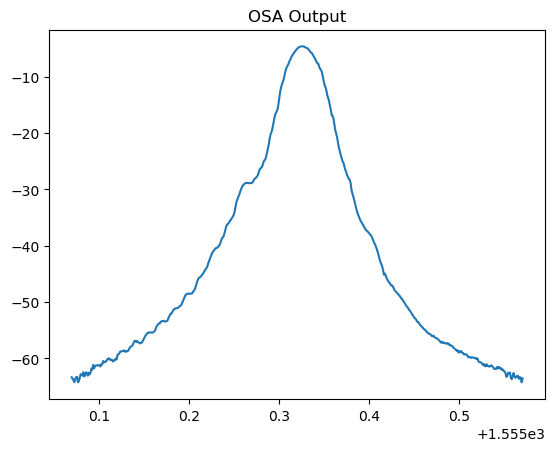

In [9]:
if __name__ == "__main__":
    path = r"C:\Users\labadmin\Documents\Steven"
    
    osa = AnritsuMS9740A('TCPIP0::128.40.39.103::inst0::INSTR') 
    osa.auto_measure()                          # perform auto measurement from OSA for analysis of OSNR of SOA coupled output
    status = int(osa.query("AUT?"))             # retreive status of auto measurement - response must be 0 to indicate measurement has successfully completed
    
    print("Auto Measurement in progress")                   

    while status == 1:                          # while auto measurement is still in progress - wait till complete before carrying on - otherwise pyvisa timeout occurs
        status = int(osa.query("AUT?"))
        time.sleep(1)
    print("Auto Measurement completed")

    osa.set_resolution(0.03)
    osa.set_x(center=1555.32, span=0.5)

    span = float(osa.query("SPN?"))                 # retreive span of OSA measurement
    centre_wavelength = float(osa.query("CNT?"))    # retreive centre wavelength of OSA measurement
    samples = float(osa.query("MPT?"))              # retreive number of sampling points of OSA measurments
    test_osa =  osa.screen_capture()                # capture the OSA output 
    wavelengths = np.arange(centre_wavelength-(span/2), centre_wavelength+(span/2), (span/samples)) # this is to ensure correct wavelengths are assigned to samples measured from OSA output
    wavelengths = np.delete(wavelengths, 1)

    plt.figure()                                        # plot this OSA output 
    plt.title("OSA Output")
    plt.plot(wavelengths, test_osa)
    plt.savefig(path + "\\SSB_Output_test.png")
    plt.show()

    data = {
        'Wavelengths': wavelengths,
        'Power(dBm)' :test_osa,
    }
    df = pd.DataFrame(data)        # save OSA output to csv file 
    df.to_csv((path + '\\OSA_output.csv'), header=True, index=False)

In [10]:
osa.close()